# Attention is All You Need — Interpretação Estatística 

Este notebook reconstrói a definição de **Self-Attention** apresentada em aula (páginas 122–125 das suas anotações).
A implementação segue o formalismo matemático desenhado na lousa:

$$
\mathrm{Att}(x) \;=\; \mathrm{softmax}\!\left(\frac{x\,L_Q\,L_K^\top\,x^\top}{\sqrt{D}}\right)\,L_V
$$

onde o mecanismo é tratado como uma **operação estatística de ponderação**: cada linha do softmax
define uma **distribuição de probabilidade condicional** sobre os tokens de referência (keys).

In [2]:
# --- Setup ---------------------------------------------------------------
set.seed(42)
options(digits = 3)

## 1️⃣ Conceito fundamental

- $x \in \mathbb{R}^{k \times m}$: sequência de $k$ tokens, cada um com $m$ parâmetros.
- $L_Q, L_K, L_V \in \mathbb{R}^{m \times D}$: projeções lineares aprendidas para **queries**, **keys** e **values**.
- $D$: dimensão latente (usada na normalização).

**Interpretação estatística:** o produto interno $QK^\top$ mede **similaridade** entre tokens;
o **softmax** transforma similaridades em **probabilidades** linha a linha.

In [3]:
# --- Funções auxiliares --------------------------------------------------

softmax_row <- function(C) {
  # Aplica softmax linha a linha (estabilidade numérica com subtração do máximo)
  C_shift <- C - apply(C, 1, max)
  expC <- exp(C_shift)
  expC / rowSums(expC)
}

attention <- function(x, L_Q, L_K, L_V, D, masked = FALSE) {
  # Implementa: Att(x) = softmax( (x L_Q L_K^T x^T) / sqrt(D) ) · L_V
  Q <- x %*% L_Q
  K <- x %*% L_K
  V <- x %*% L_V

  C <- (Q %*% t(K)) / sqrt(D)  # similaridade

  if (masked) {
    # máscara causal: proíbe olhar para o futuro (j > i)
    C[upper.tri(C, diag = FALSE)] <- -Inf
  }

  W <- softmax_row(C)          # pesos probabilísticos (cada linha soma 1)
  Att <- W %*% V               # média ponderada dos values

  list(Att = Att, W = W, C = C, Q = Q, K = K, V = V)
}

## 2️⃣ Exemplo direto com matrizes pequenas

Criamos uma sequência com **k = 4** tokens e dimensão **m = 3**.  
Usamos $D = 3$ para as projeções (propositalmente pequeno para inspecionar números).

In [4]:
# --- Exemplo base --------------------------------------------------------
k <- 4; m <- 3; D <- 3

x  <- matrix(runif(k * m), nrow = k, ncol = m)

L_Q <- matrix(runif(m * D), nrow = m, ncol = D)
L_K <- matrix(runif(m * D), nrow = m, ncol = D)
L_V <- matrix(runif(m * D), nrow = m, ncol = D)

res <- attention(x, L_Q, L_K, L_V, D, masked = FALSE)

cat("🔹 Entrada x:\n"); print(x)
cat("\n🔹 Q (x L_Q):\n"); print(res$Q)
cat("\n🔹 K (x L_K):\n"); print(res$K)
cat("\n🔹 V (x L_V):\n"); print(res$V)

cat("\n🔹 Similaridade C = Q K^T / √D:\n"); print(res$C)
cat("\n🔹 Pesos W (softmax por linha; probabilidade condicional):\n"); print(res$W)
cat("\n🔹 Saída Att(x) = W · V:\n"); print(res$Att)

🔹 Entrada x:
      [,1]  [,2]  [,3]
[1,] 0.915 0.642 0.657
[2,] 0.937 0.519 0.705
[3,] 0.286 0.737 0.458
[4,] 0.830 0.135 0.719

🔹 Q (x L_Q):
      [,1]  [,2]  [,3]
[1,] 1.323 1.565 1.388
[2,] 1.334 1.471 1.373
[3,] 0.667 1.043 0.962
[4,] 1.143 0.997 1.120

🔹 K (x L_K):
      [,1]  [,2]  [,3]
[1,] 1.383 0.662 1.665
[2,] 1.311 0.619 1.670
[3,] 1.201 0.581 0.971
[4,] 0.929 0.418 1.414

🔹 V (x L_V):
      [,1] [,2]  [,3]
[1,] 1.450 1.18 0.736
[2,] 1.386 1.23 0.754
[3,] 0.986 0.58 0.570
[4,] 1.001 1.17 0.686

🔹 Similaridade C = Q K^T / √D:
     [,1] [,2] [,3] [,4]
[1,] 2.99 2.90 2.22 2.22
[2,] 2.95 2.86 2.19 2.19
[3,] 1.86 1.81 1.35 1.40
[4,] 2.37 2.30 1.76 1.77

🔹 Pesos W (softmax por linha; probabilidade condicional):
      [,1]  [,2]  [,3]  [,4]
[1,] 0.352 0.322 0.163 0.163
[2,] 0.350 0.321 0.164 0.165
[3,] 0.314 0.298 0.190 0.198
[4,] 0.331 0.309 0.179 0.181

🔹 Saída Att(x) = W · V:
     [,1] [,2]  [,3]
[1,] 1.28 1.10 0.706
[2,] 1.28 1.09 0.706
[3,] 1.25 1.08 0.700
[4,] 1.27 1.09 0.703

## 3️⃣ Visualização: distribuição de atenção $W$

Cada linha de $W$ é uma distribuição $P(\text{token}_j \mid \text{token}_i)$.

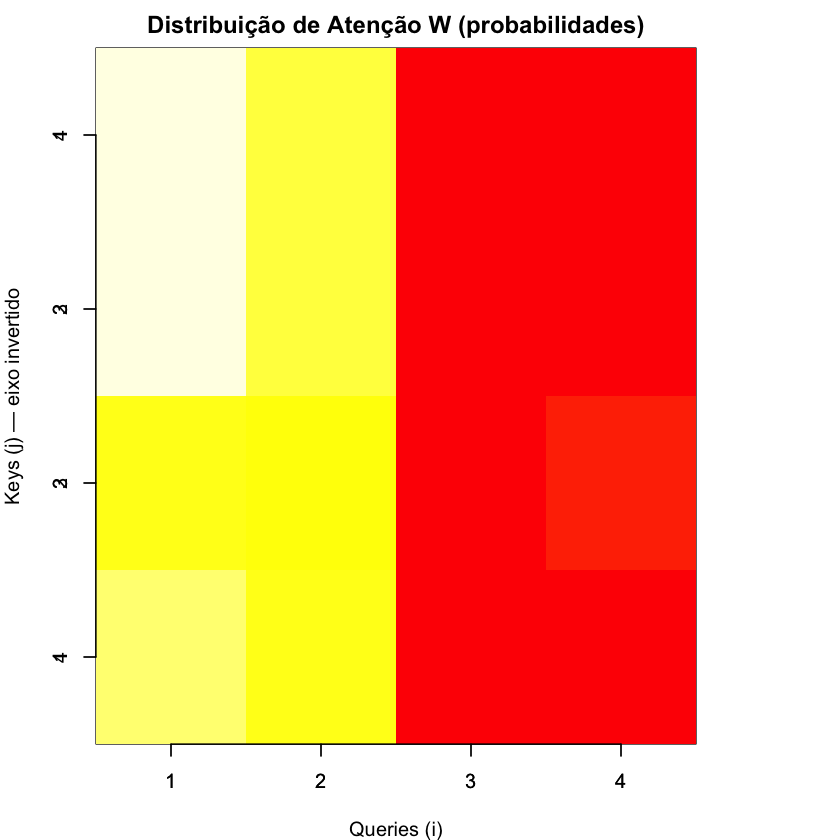

In [5]:
# --- Heatmap simples (base R) -------------------------------------------
op <- par(no.readonly = TRUE)
par(mar = c(4,4,2,6))
image(
  x = 1:nrow(res$W),
  y = 1:ncol(res$W),
  z = t(res$W[nrow(res$W):1, ]),
  xlab = "Queries (i)",
  ylab = "Keys (j) — eixo invertido",
  main = "Distribuição de Atenção W (probabilidades)",
  col = heat.colors(20)
)
axis(1, at = 1:nrow(res$W), labels = 1:nrow(res$W))
axis(2, at = 1:ncol(res$W), labels = rev(1:ncol(res$W)))
par(op)

## 4️⃣ Termo de normalização $1/\sqrt{D}$

- Sem esse fator, o produto $QK^\top$ cresce com $D$ e **satura** o softmax (distribuições quase determinísticas).
- Dividir por $\sqrt{D}$ **padroniza** a variância do produto interno, mantendo o regime numérico estável.

## 5️⃣ Fluxo com *embedding* + posição → **Attention** (como nas anotações)

Vamos reproduzir o fluxo da última figura:

$$
x^{(0)} \xrightarrow{A(\cdot) + P} x^{(1)} \xrightarrow{\text{Attention}} x^{(2)}
$$

- **A(\*)**: embedding de tokens (matriz $A \in \mathbb{R}^{V \times m}$).
- **P**: codificação posicional simples ($k \times m$).
- **Masked**: atenção causal (*autoregressiva*), proibindo que o token $i$ veja $j>i$.

In [6]:
# --- Pipeline embedding + posição + masked attention --------------------

# Vocabulário e sequência de tokens (ex.: seus números 2,4,10,20)
V <- 30
tokens <- c(2, 4, 10, 20)   # k = 4
k <- length(tokens); m <- 4; D <- 4

# Embedding A: cada token vira um vetor em R^m
A <- matrix(rnorm(V * m, sd = 0.5), nrow = V, ncol = m)
X_embed <- A[tokens, , drop = FALSE]

# Posição P: codificação simples (linear) para demonstração
# (poderia ser sen/cos, mas aqui usamos algo mínimo e transparente)
pos <- matrix(rep(seq(0, 1, length.out = k), each = m), nrow = k, byrow = TRUE)

x1 <- X_embed + pos  # x^{(1)} = A(x^{(0)}) + P

# Novas projeções para este espaço m -> D
L_Q2 <- matrix(rnorm(m * D), nrow = m, ncol = D)
L_K2 <- matrix(rnorm(m * D), nrow = m, ncol = D)
L_V2 <- matrix(rnorm(m * D), nrow = m, ncol = D)

res2 <- attention(x1, L_Q2, L_K2, L_V2, D, masked = TRUE)

cat("🔹 x^{(1)} (embedding + posição):\n"); print(x1)
cat("\n🔹 Máscara causal aplicada (C com -Inf acima da diagonal):\n"); print(res2$C)
cat("\n🔹 Pesos W (cada linha soma 1; não olha para o futuro):\n"); print(res2$W)
cat("\n🔹 Saída x^{(2)} = Att(x^{(1)}):\n"); print(res2$Att)

🔹 x^{(1)} (embedding + posição):
        [,1]   [,2]    [,3]   [,4]
[1,] -0.0808 -0.391  0.0635 -0.474
[2,]  1.1949  1.224 -0.1252  0.792
[3,]  0.1921  0.482  0.7834  1.230
[4,]  0.8413  0.397  0.3928  1.050

🔹 Máscara causal aplicada (C com -Inf acima da diagonal):
       [,1]   [,2]   [,3]  [,4]
[1,] -0.427   -Inf   -Inf  -Inf
[2,]  2.329 -13.30   -Inf  -Inf
[3,]  0.494  -3.66  1.372  -Inf
[4,]  1.035  -6.82 -0.261 -4.44

🔹 Pesos W (cada linha soma 1; não olha para o futuro):
      [,1]     [,2]  [,3]    [,4]
[1,] 1.000 0.00e+00 0.000 0.00000
[2,] 1.000 1.63e-07 0.000 0.00000
[3,] 0.292 4.57e-03 0.703 0.00000
[4,] 0.782 3.03e-04 0.214 0.00327

🔹 Saída x^{(2)} = Att(x^{(1)}):
       [,1]     [,2]   [,3]   [,4]
[1,] 0.0525 -0.42454 -0.116  0.668
[2,] 0.0525 -0.42454 -0.116  0.668
[3,] 0.3532  0.97450  1.401 -1.140
[4,] 0.1465  0.00695  0.350  0.114


## 6️⃣ Leitura estatística

- $W_{ij}$ é **probabilidade condicional** $P(j \mid i)$.
- $\mathrm{Att}(x_i) = \sum_j W_{ij} V_j$ é uma **média ponderada adaptativa** dos valores $V_j$.
- O **masked attention** impõe a causalidade para modelos de linguagem: o token atual **não pode** usar informação futura.

**Resumo:** o *self-attention* funciona como um **estimador condicional suave**, em que similaridades (produtos internos)
viram probabilidades via softmax, e as representações são atualizadas por médias ponderadas de valores.